Epoch 0: Accuracy 0.000, Average Loss 2.3028138494491577
Epoch 0: Accuracy 0.000, Average Loss 2.3027756929397585

Epoch 1: Accuracy 0.000, Average Loss 2.1821597099304197
Epoch 1: Accuracy 0.000, Average Loss 2.177372121810913

Epoch 2: Accuracy 0.000, Average Loss 2.2944155502319337
Epoch 2: Accuracy 0.000, Average Loss 2.294188070297241

Epoch 3: Accuracy 0.000, Average Loss 2.300749635696411
Epoch 3: Accuracy 0.000, Average Loss 2.3005797624588014

Epoch 4: Accuracy 0.000, Average Loss 2.256596031188965
Epoch 4: Accuracy 0.000, Average Loss 2.258112597465515

Epoch 5: Accuracy 0.000, Average Loss 2.266752872467041
Epoch 5: Accuracy 0.000, Average Loss 2.2744733333587646

Epoch 6: Accuracy 0.000, Average Loss 2.212665529251099
Epoch 6: Accuracy 0.000, Average Loss 2.21195969581604

Epoch 7: Accuracy 0.000, Average Loss 2.238858952522278
Epoch 7: Accuracy 0.000, Average Loss 2.2344735622406007

Epoch 8: Accuracy 0.018, Average Loss 2.056997423171997
Epoch 8: Accuracy 0.018, Average L

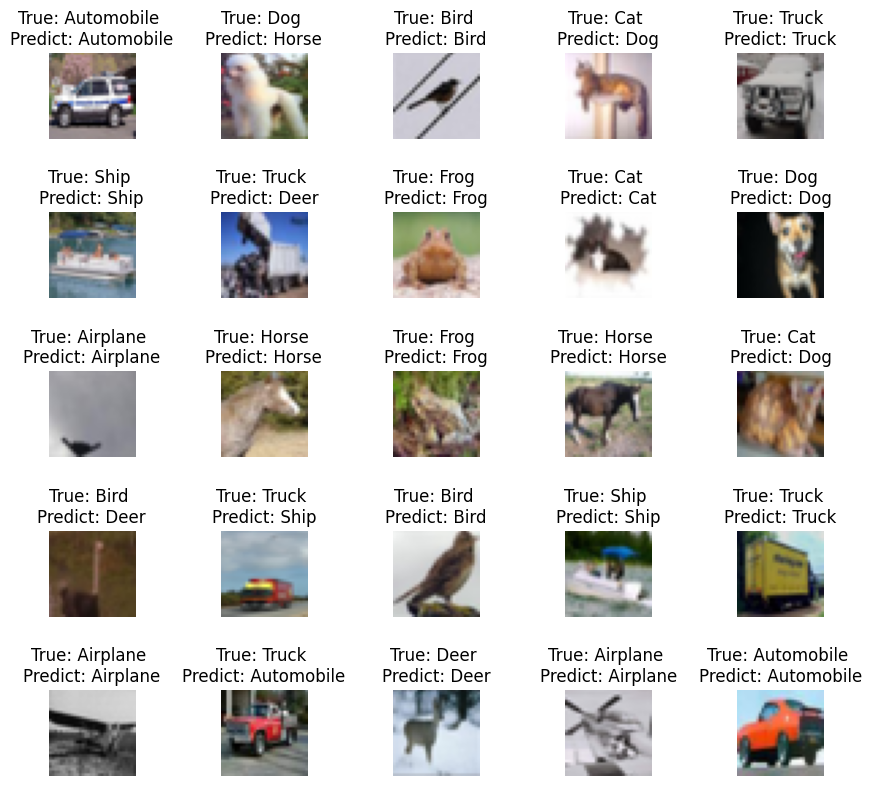

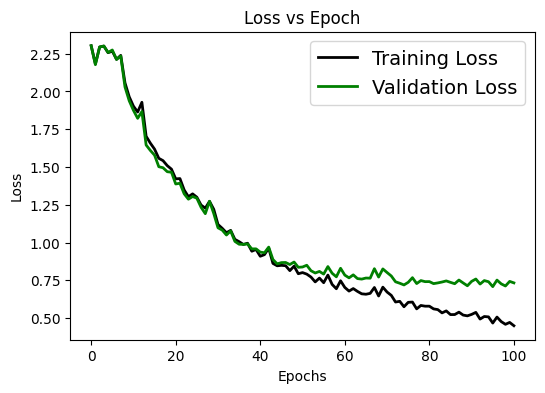

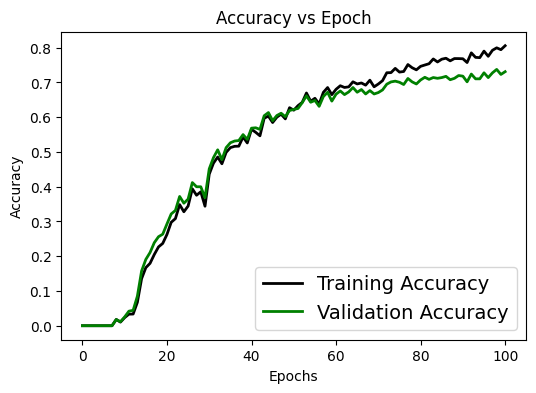

In [3]:
 # train the model

from PIL import Image

import numpy as np
import mlx.core as mx
import matplotlib.pyplot as plt

from alpineml import Network
from alpineml.layer import MyLinear, MyConv2d, MyMaxPool2d
from alpineml.layer.conv.Conv2d import Conv2d
from alpineml.layer.conv.MaxPool2d import MaxPool2d
from alpineml.layer.reshape import Flatten, Reshape, Transpose
from alpineml.optim import SGD
from alpineml.function.activation import leaky_relu, softmax, relu
from alpineml.function.loss import CrossEntropyLoss, cross_entropy_loss
from alpineml.layer.core import Linear, Activation
from dataset import get_mnist, get_fashion_mnist, get_cifar10


# Visualize
def viz_sample_predictions(network, test_data, label_map, rows=5, cols=5, figsize=(10, 10)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize, num="Sample Predictions")
    axes = axes.reshape(-1)  # flatten

    test_data = test_data.to_buffer().shuffle()
    def sample_random():
        for j in np.arange(0, rows * cols):
            i = np.random.randint(0, len(test_data))
            x = mx.array(test_data[i]['image'])
            y = mx.array(test_data[i]['label'])
            y_pred = network.forward(x[mx.newaxis, ...])

            sample = np.array(255 * x)
            if sample.shape[2] == 3:
                image = Image.fromarray(sample.astype('uint8'))
            else:
                image = Image.fromarray(sample.reshape(sample.shape[0], sample.shape[1]))

            raw_label = mx.argmax(y).item()
            label = label_map[raw_label]

            raw_pred = mx.argmax(y_pred).item()
            pred = label_map[raw_pred]

            axes[j].imshow(image)
            axes[j].set_title(f"True: {label} \nPredict: {pred}")
            axes[j].axis('off')
            plt.subplots_adjust(wspace=1)

    def on_key(event):
        if event.key == ' ':
            sample_random()
            fig.show()

    fig.canvas.mpl_connect('key_press_event', on_key)

    sample_random()


def viz_history(history, figsize=(6, 4)):
    plt.figure(figsize=figsize, num="Loss Curves")
    plt.plot(history['epoch'], history['train_loss'], 'black', linewidth=2.0)
    plt.plot(history['epoch'], history['test_loss'], 'green', linewidth=2.0)
    plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
    plt.xlabel('Epochs', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.title('Loss vs Epoch', fontsize=12)

    plt.figure(figsize=figsize, num="Accuracy Curves")
    plt.plot(history['epoch'], history['train_accuracy'], 'black', linewidth=2.0)
    plt.plot(history['epoch'], history['test_accuracy'], 'green', linewidth=2.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
    plt.xlabel('Epochs', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.title('Accuracy vs Epoch', fontsize=12)


# Evaluate
def eval_model(model, dataset, epoch=None):
    mean_losses = []
    accuracies = []
    predictions = []

    for batch in dataset:
        x_batch = mx.array(batch["image"])
        y_batch = mx.array(batch["label"])

        y_pred = model.forward(x_batch)
        predictions.append(y_pred)

        loss = optimizer.loss_fn(y_pred, y_batch)
        mean_loss = mx.mean(mx.sum(loss, axis=1))
        mean_losses.append(mean_loss.item())

        if isinstance(optimizer.loss_fn, CrossEntropyLoss):
            y_pred = softmax(y_pred)

        errors = mx.sum(mx.abs(y_batch - mx.round(y_pred)), axis=1)
        accuracy = mx.sum(errors == 0) / y_batch.shape[0]
        accuracies.append(accuracy.item())

    mean_loss = sum(mean_losses) / len(mean_losses)
    accuracy = sum(accuracies) / len(accuracies)
    predictions = np.concatenate(predictions)

    dataset.reset()

    if epoch is not None:
        print(f"Epoch {epoch}: Accuracy {accuracy:.3f}, Average Loss {mean_loss}")
    else:
        print(f"Accuracy {accuracy:.3f}, Average Loss {mean_loss}")

    return predictions, accuracy, mean_loss


def train(train_data, epochs, batch_size=1, test_data=None, cb=None):
    batched_train_data = train_data.batch(batch_size)
    batched_test_data = test_data.batch(batch_size)

    def train_epoch():
        for batch in batched_train_data:
            x_batch = mx.array(batch["image"])
            y_batch = mx.array(batch["label"])
            optimizer.step(x_batch, y_batch)
        batched_train_data.reset()

    history = {"epoch": [], "train_loss": [], "test_loss": [], "train_accuracy": [], "test_accuracy": []}

    _, train_accuracy, train_loss = eval_model(network, batched_train_data, epoch=0)
    _, test_accuracy, test_loss = eval_model(network, batched_test_data, epoch=0)
    print()
    history["epoch"].append(0)
    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["train_accuracy"].append(train_accuracy)
    history["test_accuracy"].append(test_accuracy)

    for epoch in range(1, epochs + 1):
        train_epoch()

        _, train_accuracy, train_loss = eval_model(network, batched_train_data, epoch=epoch)
        _, test_accuracy, test_loss = eval_model(network, batched_test_data, epoch=epoch)
        print()
        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["train_accuracy"].append(train_accuracy)
        history["test_accuracy"].append(test_accuracy)

    test_data.reset()
    eval_model(network, batched_test_data)
    print()

    viz_sample_predictions(network, test_data, label_map)
    viz_history(history)
    plt.show()


# train_data, test_data = get_mnist(static=True)  # 97% max accuracy
# label_map = ["Zero", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine"]

# train_data, test_data = get_fashion_mnist(static=True)  # 87% max accuracy
# label_map = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

train_data, test_data = get_cifar10(static=False) #
label_map = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

network = Network(input_shape=(32, 32, 3))

# # feed forward
# network.add_layer(Flatten())
# network.add_layer(Activation(leaky_relu))
# network.add_layer(MyLinear(256))
# network.add_layer(Activation(leaky_relu))
# network.add_layer(MyLinear(256))
# network.add_layer(Activation(leaky_relu))
# network.add_layer(MyLinear(256))
# network.add_layer(Activation(leaky_relu))
# network.add_layer(MyLinear(128))
# network.add_layer(Activation(leaky_relu))
# network.add_layer(MyLinear(10))
# network.add_layer(Activation(leaky_relu))

# conv block 1
network.add_layer(MyConv2d(out_channels=96, kernel_size=7))
network.add_layer(Activation(leaky_relu))
network.add_layer(MyMaxPool2d(2))
# conv block 2
network.add_layer(MyConv2d(out_channels=256, kernel_size=3))
network.add_layer(Activation(leaky_relu))
network.add_layer(MyMaxPool2d(2))
# # conv block 3
# network.add_layer(MyConv2d(out_channels=384, kernel_size=3))
# network.add_layer(Activation(leaky_relu))
# network.add_layer(MyMaxPool2d(2))
# feed forward
network.add_layer(Flatten())
network.add_layer(Linear(1024))
network.add_layer(Flatten())
network.add_layer(Linear(1024))
network.add_layer(Activation(leaky_relu))
network.add_layer(Linear(10))

optimizer = SGD(eta=0.05, momentum=0.9, weight_decay=0.0005)
optimizer.bind_loss_fn(cross_entropy_loss)
optimizer.bind_network(network)

train(train_data, epochs=100, batch_size=1000, test_data=test_data)


Kernel Shape: (96, 7, 7, 3)
Example: [[[-4.36037220e-02 -3.56434584e-02  1.81939621e-02]
  [-5.95389195e-02  5.33478186e-02  2.01896671e-02]
  [-5.53404242e-02  1.35659091e-02 -5.93127497e-02]
  [ 2.29534805e-02  1.55236825e-01  2.17706263e-02]
  [-4.76499572e-02  2.56145541e-02  1.61458701e-02]
  [-1.37503386e-01 -9.59385335e-02  7.82358274e-03]
  [ 4.32158448e-02 -1.40759451e-02  8.76771510e-02]]

 [[ 2.36098934e-02 -8.48711953e-02  9.55367908e-02]
  [-8.63782838e-02 -2.41328850e-02 -2.06551328e-02]
  [-4.13600430e-02  9.74587537e-03 -1.21863991e-01]
  [ 1.86302781e-01  2.30012894e-01  1.14412867e-01]
  [ 1.12523414e-01  1.75359026e-01  1.11970343e-01]
  [-1.90308675e-01 -1.51655927e-01 -2.33191550e-01]
  [-6.41671801e-03  4.53199558e-02 -6.80776089e-02]]

 [[ 1.93337984e-02 -1.63935237e-02  5.96343912e-02]
  [-5.69268018e-02 -9.68987420e-02 -8.08703527e-02]
  [-2.78186738e-01 -1.73415706e-01 -2.56448954e-01]
  [-2.65081748e-02  1.22898981e-01 -3.92074138e-02]
  [ 6.27120554e-01  6.5

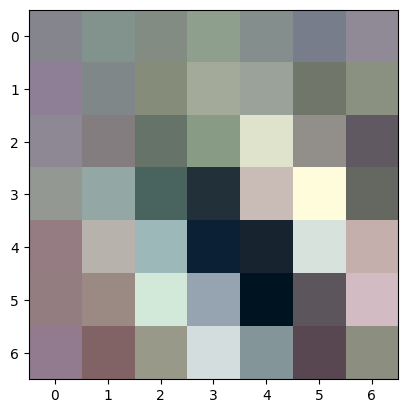

In [26]:
kernels = network.layers[0].params['W']
kernel = np.array(kernels[50])
print("Kernel Shape:", kernels.shape)
print("Example:", kernel)

def normalize(kernel):
    kernel -= np.min(kernel)
    kernel /= np.max(kernel)
    return (255 * kernel).astype(np.uint8)

kernel_img = Image.fromarray(normalize(kernel))
plt.imshow(kernel_img)

Mins 0.013281564 0.0 0.042983778
Maxs 0.95591617 1.0 0.98496306


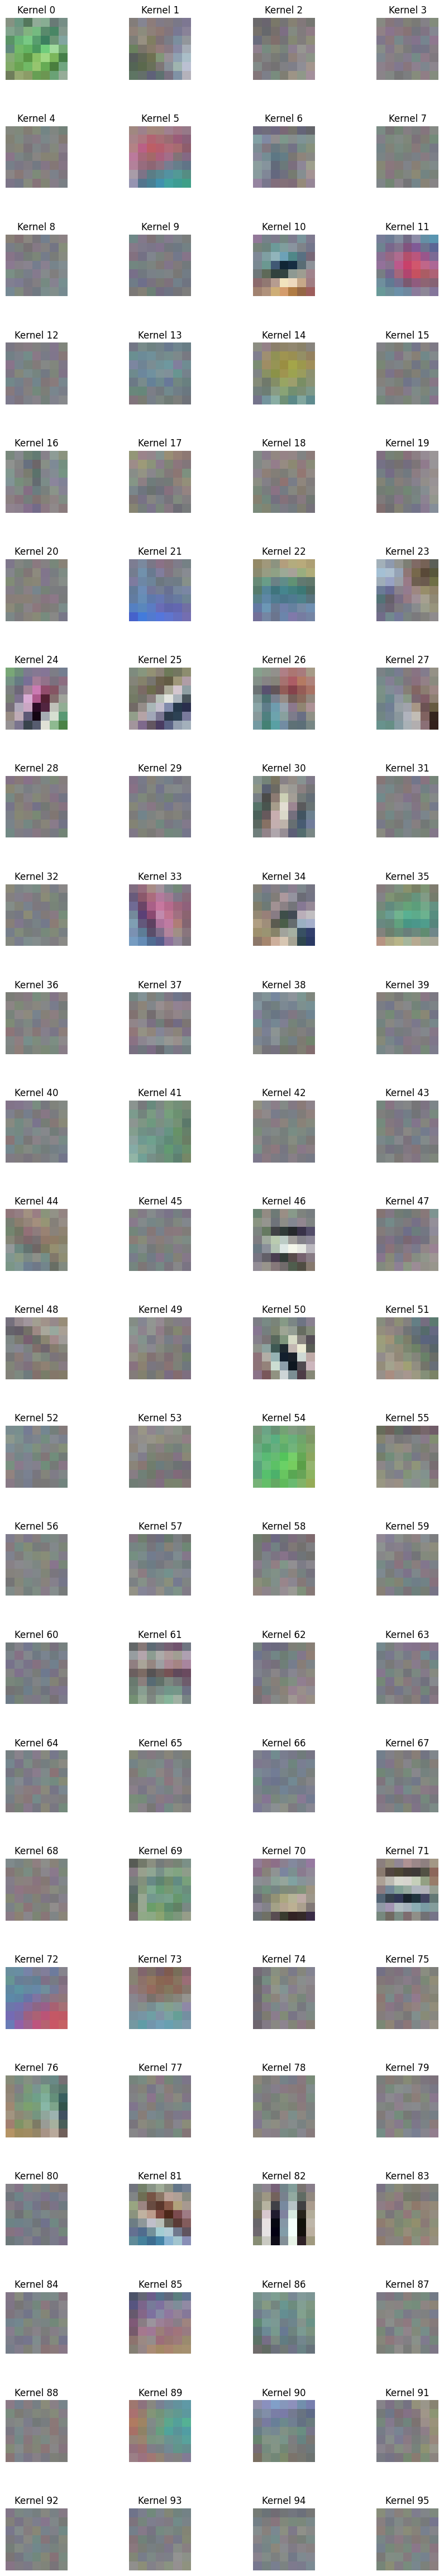

In [105]:
def viz_kernels(kernels, rows=24, cols=4, figsize=(10, 60)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize, num="Sample Predictions")
    axes = axes.reshape(-1)  # flatten

    def normalize_kernels(kernels):
        kernels = np.array(kernels)

        kernels = 1 / (1 + np.exp(-2 * kernels))
        kernels = kernels - np.min(kernels)
        kernels = kernels / np.max(kernels)

        # r_min, g_min, b_min = np.min(kernels[:, :, :, 0]), np.min(kernels[:, :, :, 1]), np.min(kernels[:, :, :, 2])
        # kernels -= np.array([r_min, g_min, b_min])
        # r_max, g_max, b_max = np.max(kernels[:, :, :, 0]), np.max(kernels[:, :, :, 1]), np.max(kernels[:, :, :, 2])
        # kernels /= np.array([r_max, g_max, b_max])
        # kernels = np.square(kernels)

        print("Mins", np.min(kernels[:, :, :, 0]), np.min(kernels[:, :, :, 1]), np.min(kernels[:, :, :, 2]))
        print("Maxs", np.max(kernels[:, :, :, 0]), np.max(kernels[:, :, :, 1]), np.max(kernels[:, :, :, 2]))

        return kernels

    kernels = normalize_kernels(kernels)

    def normalize(kernel):
        return (255 * kernel).astype(np.uint8)

    def imagize(kernel):
        return Image.fromarray(normalize(kernel))

    for j, kernel in enumerate(kernels):
        kernel_img = imagize(kernel)
        axes[j].imshow(kernel_img)
        axes[j].set_title(f"Kernel {j}")
        axes[j].axis('off')
        plt.subplots_adjust(wspace=1)

    plt.show()

viz_kernels(network.layers[0].params['W'])